Step 1: Data Cleaning 

In [1]:
import pandas as pd
df = pd.read_csv("heart_2020_cleaned.csv", nrows=50000)
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      50000 non-null  object 
 1   BMI               50000 non-null  float64
 2   Smoking           50000 non-null  object 
 3   AlcoholDrinking   50000 non-null  object 
 4   Stroke            50000 non-null  object 
 5   PhysicalHealth    50000 non-null  float64
 6   MentalHealth      50000 non-null  float64
 7   DiffWalking       50000 non-null  object 
 8   Sex               50000 non-null  object 
 9   AgeCategory       50000 non-null  object 
 10  Race              50000 non-null  object 
 11  Diabetic          50000 non-null  object 
 12  PhysicalActivity  50000 non-null  object 
 13  GenHealth         50000 non-null  object 
 14  SleepTime         50000 non-null  float64
 15  Asthma            50000 non-null  object 
 16  KidneyDisease     50000 non-null  object

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


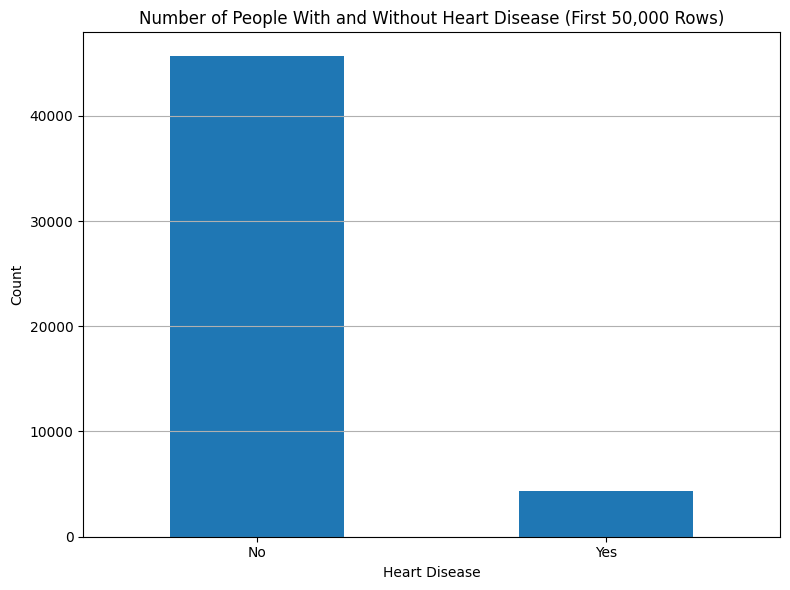

In [2]:
import pandas as pd
import matplotlib.pyplot as plt



# Plotting the number of people with and without heart disease
plt.figure(figsize=(8, 6))
df['HeartDisease'].value_counts().plot(kind='bar')
plt.title('Number of People With and Without Heart Disease (First 50,000 Rows)')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [3]:
binary_cols = [
    'HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke',
    'DiffWalking', 'Diabetic', 'PhysicalActivity',
    'Asthma', 'KidneyDisease', 'SkinCancer'
]

df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'Yes' else 0)

/var/folders/gp/9b_fhx0s24s2954c8mqgvr240000gn/T/ipykernel_60282/918804490.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'Yes' else 0)


In [4]:
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})

In [5]:
df['ComorbidityCount'] = df[['Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']].sum(axis=1)

In [6]:
df['UnhealthyDays'] = df['PhysicalHealth'] + df['MentalHealth']
df['UnhealthyDays'] = df['UnhealthyDays'].clip(upper=30)

In [7]:
df['RiskBehavior'] = ((df['Smoking'] == 1) | (df['AlcoholDrinking'] == 1)).astype(int)

In [8]:
df['SleepCategory'] = pd.cut(df['SleepTime'],
                             bins=[0, 5, 6.9, 8.9, 24],
                             labels=['Very Short', 'Short', 'Normal', 'Long'])

In [9]:
df = pd.get_dummies(df, columns = ['AgeCategory', 'Race', 'GenHealth', 'SleepCategory'], 
                    prefix = ['Age', 'Race', 'GenHealth', 'SleepCategory'], drop_first=False, dtype = int)

In [10]:
df.dtypes

HeartDisease                             int64
BMI                                    float64
Smoking                                  int64
AlcoholDrinking                          int64
Stroke                                   int64
PhysicalHealth                         float64
MentalHealth                           float64
DiffWalking                              int64
Sex                                      int64
Diabetic                                 int64
PhysicalActivity                         int64
SleepTime                              float64
Asthma                                   int64
KidneyDisease                            int64
SkinCancer                               int64
ComorbidityCount                         int64
UnhealthyDays                          float64
RiskBehavior                             int64
Age_18-24                                int64
Age_25-29                                int64
Age_30-34                                int64
Age_35-39    

In [11]:
df.to_csv("heart_cleaned_final.csv", index=False)

In [12]:
from sklearn.model_selection import train_test_split
import pickle


X = df.drop("HeartDisease", axis=1)  
y = df["HeartDisease"]              


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 3: Save each set as a Pickle (.p) file
pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))
pickle.dump(y_train, open("y_train.p", "wb"))
pickle.dump(y_test, open("y_test.p", "wb"))

print("Pickle files saved successfully!")

Pickle files saved successfully!


In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import numpy as np
import pandas as pd
import sample_data as sd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
rs = 1234

In [14]:
spw = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train)
spw

10.490479317137229

In [15]:
df.dtypes

HeartDisease                             int64
BMI                                    float64
Smoking                                  int64
AlcoholDrinking                          int64
Stroke                                   int64
PhysicalHealth                         float64
MentalHealth                           float64
DiffWalking                              int64
Sex                                      int64
Diabetic                                 int64
PhysicalActivity                         int64
SleepTime                              float64
Asthma                                   int64
KidneyDisease                            int64
SkinCancer                               int64
ComorbidityCount                         int64
UnhealthyDays                          float64
RiskBehavior                             int64
Age_18-24                                int64
Age_25-29                                int64
Age_30-34                                int64
Age_35-39    

In [16]:
from xgboost import XGBClassifier ## There's more variety here as well XGBRegressor, XGBFClassifier, XGBFRegressor

xg_cl = XGBClassifier(objective='binary:logistic', ## Objective function can be changed for specific case - there are many options!
                        n_estimators = 100, ## Default is 100
                        max_depth = 6, ## Default is 6
                        eta = 0.3, ## AKA learning_rate, but XGB restricts it to [0,1], Default = 0.3,
                        scale_pos_weight = spw, ## Treat the datata as balanced
                        seed = rs) ## different name, same thing, random_state

xg_cl.fit(X_train,y_train)

#Predict the model - works the same
y_train_hat = xg_cl.predict(X_train)
y_test_hat = xg_cl.predict(X_test)

## We do still have the 'score' function as in sklearn
xg_cl.score(X_train, y_train), xg_cl.score(X_test, y_test) ## we set `binary:logisitc` on a Classifier, so score is Accuracy

(0.8542857142857143, 0.7976666666666666)

In [17]:
## Base
clf = XGBClassifier(objective='binary:logistic', scale_pos_weight = spw, seed = rs) 

## KFold Stratified
from sklearn.model_selection import StratifiedKFold
cv_5 = StratifiedKFold(n_splits=5)

## Parameter Grid
param_grid = {'max_depth': np.arange(5,12,1),
              'n_estimators': np.arange(75,100,5),
              'eta': np.arange(.3,.5,.1),
              'min_child_weight': [1, 2, 3],
            'scale_pos_weight': [1, 2, 3]}

## Run the Grid search
sh = RandomizedSearchCV(clf,
                         param_grid,
                         n_iter = 50,
                         cv = cv_5,
                         random_state = rs,).fit(X_train, y_train)
sh.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=75,
              n_jobs=None, num_parallel_tree=None, ...)

In [18]:
xg_cl = sh.best_estimator_

#Predict the model - works the same
y_train_hat = xg_cl.predict(X_train)
y_test_hat = xg_cl.predict(X_test)

## We do still have the 'score' function as in sklearn
xg_cl.score(X_train, y_train), xg_cl.score(X_test, y_test)

(0.9293428571428571, 0.9118666666666667)

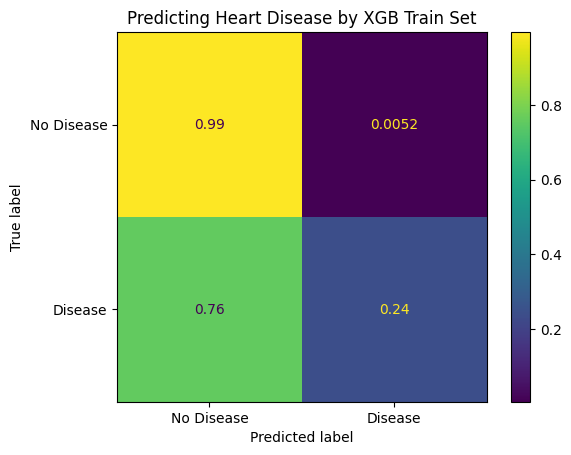

In [19]:
labels_ = ['No Disease', 'Disease']

cm_train = confusion_matrix(y_train, y_train_hat, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels_)
disp.plot()
plt.title("Predicting Heart Disease by XGB Train Set")
plt.grid(False)
plt.show()

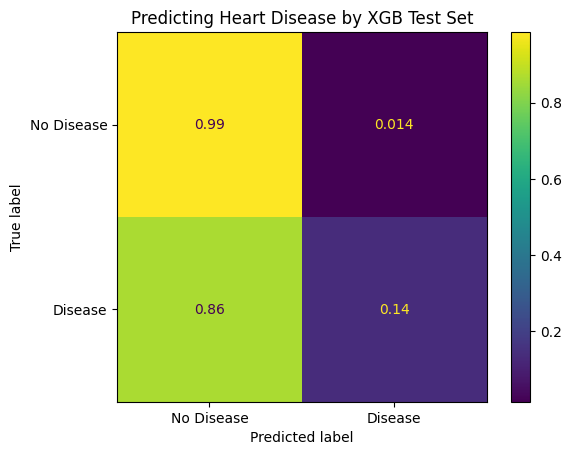

In [20]:
cm_test = confusion_matrix(y_test, y_test_hat, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= labels_)
disp.plot()
plt.title("Predicting Heart Disease by XGB Test Set")
plt.grid(False)
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [22]:
# Predict on test set
y_pred = xg_cl.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")

Accuracy:  0.91
Precision: 0.48
Recall:    0.14


In [23]:
# Predict probabilities for ROC AUC
y_proba = xg_cl.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"F1 Score:  {f1:.2f}")
print(f"ROC AUC:   {roc_auc:.2f}")

F1 Score:  0.22
ROC AUC:   0.82


The model has high accuracy (0.91) but low recall (0.14), meaning it misses most heart disease cases. Precision (0.48) is also low, leading to false positives. The F1 score (0.22) reflects poor balance between precision and recall, while the ROC AUC (0.82) shows good overall class differentiation. Improving recall is crucial to avoid missing heart disease cases.
Probable Cause: Dataset Class Imbalance between NoHeartDisease/HeartDisease respectively,(45,648/4,352)

In [24]:
df_tree = xg_cl.get_booster().trees_to_dataframe()
df_tree.head(10)

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,ComorbidityCount,2.0,0-1,0-2,0-2,976.216797,4724.306150,NaN
1,0,1,0-1,DiffWalking,1.0,0-3,0-4,0-4,419.088623,4347.576170,NaN
2,0,2,0-2,Stroke,1.0,0-5,0-6,0-6,129.842499,376.729645,NaN
3,0,3,0-3,Age_80 or older,1.0,0-7,0-8,0-8,149.806885,3830.737300,NaN
4,0,4,0-4,Stroke,1.0,0-9,0-10,0-10,65.573822,516.839050,NaN
5,0,5,0-5,DiffWalking,1.0,0-11,0-12,0-12,69.850998,268.205597,NaN
6,0,6,0-6,GenHealth_Very good,1.0,0-13,0-14,0-14,33.572876,108.524055,NaN
7,0,7,0-7,ComorbidityCount,1.0,0-15,0-16,0-16,105.684814,3599.786130,NaN
8,0,8,0-8,Sex,1.0,0-17,0-18,0-18,35.201023,230.951080,NaN
9,0,9,0-9,GenHealth_Poor,1.0,0-19,0-20,0-20,52.831093,489.573090,NaN


In [25]:
df_tree.shape

(3841, 11)

In [26]:
## tells us how many splits were done 
df_tree[df_tree['Feature'] != 'Leaf'].shape[0]

1883

In [27]:
df_tree_features = df_tree[df_tree['Feature'] != 'Leaf'].copy()
df_tree_features

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,ComorbidityCount,2.000000,0-1,0-2,0-2,976.216797,4724.306150,NaN
1,0,1,0-1,DiffWalking,1.000000,0-3,0-4,0-4,419.088623,4347.576170,NaN
2,0,2,0-2,Stroke,1.000000,0-5,0-6,0-6,129.842499,376.729645,NaN
3,0,3,0-3,Age_80 or older,1.000000,0-7,0-8,0-8,149.806885,3830.737300,NaN
4,0,4,0-4,Stroke,1.000000,0-9,0-10,0-10,65.573822,516.839050,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3808,74,24,74-24,BMI,36.580002,74-47,74-48,74-48,0.732548,4.485965,NaN
3809,74,25,74-25,GenHealth_Very good,1.000000,74-49,74-50,74-50,1.045059,4.408062,NaN
3810,74,26,74-26,Sex,1.000000,74-51,74-52,74-52,3.796722,8.525488,NaN
3811,74,27,74-27,MentalHealth,5.000000,74-53,74-54,74-54,3.579046,15.346827,NaN


In [28]:
df_import = df_tree_features[['Feature','Gain']].copy()

## We can look at summary stats using .groupby()
## Let's look at mean, max, and quantile(0.95)
df_import.groupby('Feature')[['Gain']].quantile(0.95).sort_values(by = 'Gain',ascending=False).reset_index()

,Feature,Gain
0,DiffWalking,115.867584
1,Age_80 or older,91.714090
2,GenHealth_Excellent,91.030835
3,Stroke,71.457689
4,Smoking,49.810649
5,Age_25-29,44.986475
6,GenHealth_Good,44.838613
7,Age_18-24,40.519531
8,Age_35-39,40.496554
9,Age_75-79,40.467848


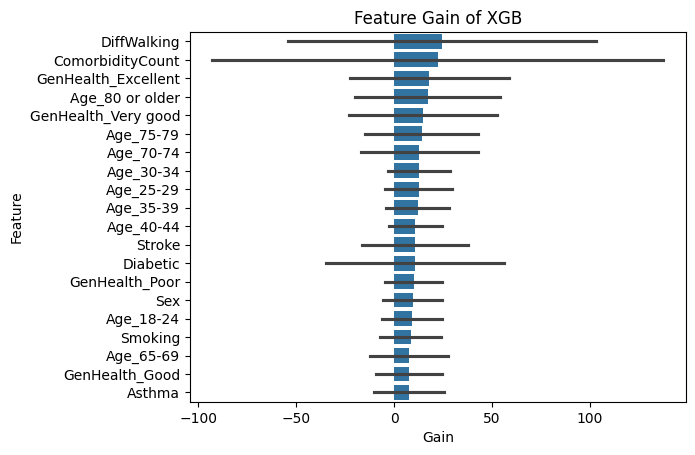

In [29]:
order_ = df_import.groupby('Feature')['Gain'].mean().sort_values(ascending=False).nlargest(20).index

sns.barplot(data = df_import,
            y = 'Feature',
            x = 'Gain', 
            errorbar = 'sd', 
            order = order_);
plt.title("Feature Gain of XGB");

In [30]:
df_tree_features.groupby(['Feature'])[['Split']].count().reset_index().sort_values("Split", ascending = False)

,Feature,Split
15,BMI,463
39,SleepTime,142
27,PhysicalHealth,117
42,UnhealthyDays,111
25,MentalHealth,106
16,ComorbidityCount,88
35,Sex,58
23,GenHealth_Very good,41
26,PhysicalActivity,38
41,Stroke,37


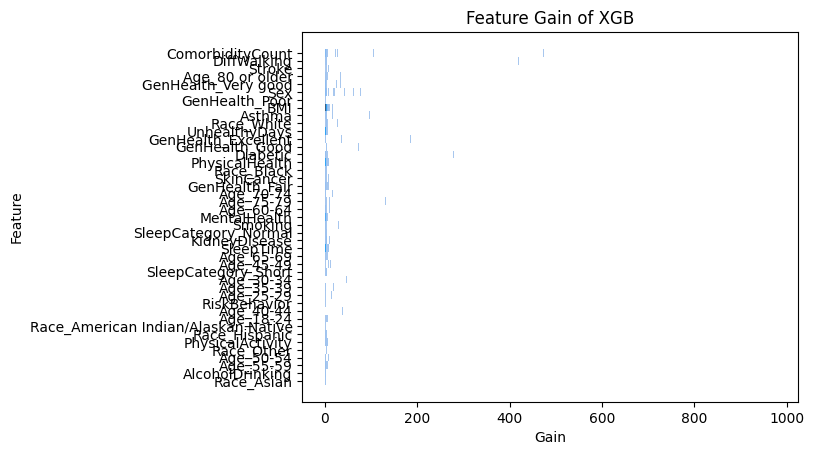

In [31]:
## The Histplot is a lot easier now actually from the df_features table

## I still need to force an ordering on the Variable Column to 
## organize the HistPlot
## I will resuse the `order_` from before
df_import['Feauture'] = pd.Categorical(df_import['Feature'],
                                       ordered = True,
                                       categories = order_)

sns.histplot(data = df_import[df_import['Gain'] < 1000],
            y = 'Feature',
            x = 'Gain');
plt.title("Feature Gain of XGB");

In [33]:
with open('xgb_model2.pkl', 'wb') as f:
    pickle.dump(xg_cl, f)